# Image Study

## The theory

We will investigate three types of networks in thie notebook to evaluate their performances and then decide which is the best one. First, a basic **CNN** created **from scratch**. Then, a much more complex **pretrained model from Huggingface**, which will be modified as its last layer is a classification one and our problem is regression based. Finally, we will investigate about **3D-CNNs**, a special variant of tghe standard CNNs that not only analyzes images with the usual 2 diensions: Height and width, but also with **time**.

For the inputs, we will extract 8 frames from each tiktok and use them as a valid representation of what the tiktok is. This means that, no matter what the batch size of our networks are, the input of the networks will be 8 images of 3 channels per tiktok.

In [1]:
from image_utils import remove_mp4_extensions, extract_frames, rename_frames_ids
import numpy as np
import pandas as pd
import os
import re
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from pathlib import Path
import sys
import PIL

In [2]:
root_dir = Path.cwd().resolve().parent.parent
sys.path.append(str(root_dir))
from config.variables import text_path, json_file, csv_file, textcsv_file

## Frame extraction

In [3]:
extract_frames()
# remove_mp4_extensions()

Saved: ../../data/inputs/frames\6875317312082201857_frame_0.png | Frame ID: 0
Saved: ../../data/inputs/frames\6875317312082201857_frame_1.png | Frame ID: 30
Saved: ../../data/inputs/frames\6875317312082201857_frame_2.png | Frame ID: 61
Saved: ../../data/inputs/frames\6875317312082201857_frame_3.png | Frame ID: 91
Saved: ../../data/inputs/frames\6875317312082201857_frame_4.png | Frame ID: 122
Saved: ../../data/inputs/frames\6875317312082201857_frame_5.png | Frame ID: 152
Saved: ../../data/inputs/frames\6875317312082201857_frame_6.png | Frame ID: 183
Saved: ../../data/inputs/frames\6875317312082201857_frame_7.png | Frame ID: 213
Saved: ../../data/inputs/frames\6875323773755657474_frame_0.png | Frame ID: 0
Saved: ../../data/inputs/frames\6875323773755657474_frame_1.png | Frame ID: 67
Saved: ../../data/inputs/frames\6875323773755657474_frame_2.png | Frame ID: 134
Saved: ../../data/inputs/frames\6875323773755657474_frame_3.png | Frame ID: 201
Saved: ../../data/inputs/frames\6875323773755657

In [3]:
# rename_frames_ids()

Renombrado: 6875317312082201857_frame_0.png a 6875317312082201857_frame_0.png
Renombrado: 6875317312082201857_frame_24.png a 6875317312082201857_frame_1.png
Renombrado: 6875317312082201857_frame_47.png a 6875317312082201857_frame_2.png
Renombrado: 6875317312082201857_frame_71.png a 6875317312082201857_frame_3.png
Renombrado: 6875317312082201857_frame_95.png a 6875317312082201857_frame_4.png
Renombrado: 6875317312082201857_frame_118.png a 6875317312082201857_frame_5.png
Renombrado: 6875317312082201857_frame_142.png a 6875317312082201857_frame_6.png
Renombrado: 6875317312082201857_frame_166.png a 6875317312082201857_frame_7.png
Renombrado: 6875317312082201857_frame_189.png a 6875317312082201857_frame_8.png
Renombrado: 6875317312082201857_frame_213.png a 6875317312082201857_frame_9.png
Renombrado: 6875323773755657474_frame_0.png a 6875323773755657474_frame_0.png
Renombrado: 6875323773755657474_frame_52.png a 6875323773755657474_frame_1.png
Renombrado: 6875323773755657474_frame_104.png a 6

## Data loading

In [3]:
from tensorflow.keras.preprocessing import image

def load_images(num_frames=8, img_height=224, img_width=224):
    dir = os.path.join(root_dir, 'data', 'inputs', 'frames')
    csv_path = os.path.join(root_dir, csv_file)
    df = pd.read_csv(csv_path, dtype={'id': str})
    X = []
    y = []

    # Iterar sobre cada fila del DataFrame
    for idx, row in df.iterrows():
        id_video = row['id']
        print(id_video)
        frames = []
        
        for j in range(num_frames):
            img_path = os.path.join(dir, f"{id_video}_frame_{j}.png")
            if os.path.exists(img_path):
                img = image.load_img(img_path, target_size=(img_height, img_width))
                img_array = image.img_to_array(img)
                frames.append(img_array)

        if len(frames) == num_frames:
            X.append(frames)
            y.append(row['norm_virality'])

    X = np.array(X) / 255.0
    y = np.array(y)

    return X, y

In [4]:
X, y = load_images()


6907228749016714497
6875468410612993286
6898699405898059010
6902819837345533186
6905635666588192002
6895497835681287426
6895303013867539713
6884590643327290625
6906514963569888513
6894206452450217217
6902751117805899009
6886417103046380801
6883211681988627714
6892769736589888770
6906571896683285761
6907334602017344774
6883094233935252737
6906818204966915330
6876318382703070465
6900948690186407170
6875323773755657474
6884935459110178049
6892805816492084481
6886765050355289346
6875370613523909890
6890189236130073857
6901321371113032962
6893611785295793410
6904536120755768578
6888873392234056962
6879952519586450690
6884933059758755073
6895846066961337601
6884933447480003842
6883604590525156609
6886215675350666497
6899411430660001026
6898613799402753281
6885861410329332998
6879772200065436929
6893119957534510338
6881624031561354498
6896541657471241474
6884688821976354049
6906870391466216709
6901020148426099969
6898035916682710274
6901681280128208130
6887645369895898369
6905029441760578818


In [5]:
X.shape

(1000, 8, 224, 224, 3)

In [6]:
X_train, X_test_valid, y_train, y_test_valid = train_test_split(X, y, test_size=0.20, random_state=42)

X_test, X_valid, y_test, y_valid = train_test_split(X_test_valid, y_test_valid, test_size=0.50, random_state=42)
print("Train set:", len(X_train))
print("Validation set:", len(X_valid))
print("Test set:", len(X_test))

Train set: 800
Validation set: 100
Test set: 100


## CNN

In [54]:
model = Sequential([
    TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=(8, 224, 224, 3)),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Conv2D(64, (3, 3), activation='relu')),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Conv2D(64, (3, 3), activation='relu')),
    TimeDistributed(GlobalAveragePooling2D()),  # Reduce cada frame a un vector
    TimeDistributed(Flatten()),  # Asegúrate de que cada salida sea un vector plano
    Flatten(),  
    Dense(64, activation='relu'),
    Dense(1)
])

# Compilar el modelo
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

c:\Users\ignac\Desktop\ICAI\TikTok-sentiment-analysis\tiktok\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [55]:
model.fit(X_train, y_train, epochs=1, batch_size=16, validation_data=(X_test, y_test))


In [12]:
model.save_weights('8framesCNN.weights.h5')

In [13]:
#load weights
model.load_weights('8framesCNN.weights.h5')

In [14]:
train_mse, train_mae = model.evaluate(X_train, y_train, verbose=0)

# Evaluación en el conjunto de validación
valid_mse, valid_mae = model.evaluate(X_valid, y_valid, verbose=0)

In [15]:
train_rmse = np.sqrt(train_mse)
valid_rmse = np.sqrt(valid_mse)

In [16]:
print("Training Metrics:")
print("RMSE:", train_rmse)
print("MSE:", train_mse)
print("MAE:", train_mae)

print("\nValidation Metrics:")
print("RMSE:", valid_rmse)
print("MSE:", valid_mse)
print("MAE:", valid_mae)

Training Metrics:
RMSE: 0.019235054068572656
MSE: 0.0003699873050209135
MAE: 0.003626070683822036

Validation Metrics:
RMSE: 0.10009287380796127
MSE: 0.01001858338713646
MAE: 0.011656389571726322


## PRETRAINED

In [7]:
import torch
from transformers import ViTModel, ViTConfig


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Cargar la configuración del modelo ViT preentrenado
config = ViTConfig.from_pretrained('google/vit-base-patch16-224-in21k')

# Indicamos que no cargue la cabeza de clasificación
config.num_labels = 1

# Cargar el modelo ViT
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k', config=config)

c:\Users\ignac\Desktop\ICAI\TikTok-sentiment-analysis\tiktok\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\ignac\Desktop\ICAI\TikTok-sentiment-analysis\tiktok\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [8]:
from torch import nn


class ViTForMultiImageRegression(nn.Module):
    def __init__(self, vit_model, num_images=8):
        super(ViTForMultiImageRegression, self).__init__()
        self.num_images = num_images
        self.vit = vit_model  # El modelo base ViT
        self.regressor = nn.Linear(config.hidden_size * num_images, 1)  # Adaptamos la entrada de la capa lineal

    def forward(self, pixel_values):
        batch_size = pixel_values.shape[0]
        combined_output = []

        # Procesar cada imagen individualmente
        for i in range(self.num_images):
            output = self.vit(pixel_values=pixel_values[:, i])
            cls_token = output.last_hidden_state[:, 0]
            combined_output.append(cls_token)

        # Concatenar las representaciones de todas las imágenes
        combined_output = torch.cat(combined_output, dim=1)
        
        return self.regressor(combined_output)
    
regression_model = ViTForMultiImageRegression(model).to(device)


In [9]:
print(regression_model)

ViTForMultiImageRegression(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=

In [10]:
num_layers_to_unfreeze = 4  # Ajusta esto según tus necesidades

# Iterar sobre los parámetros y hacerlos entrenables según la condición
for name, param in regression_model.named_parameters():
    # Esto activará el entrenamiento para las últimas N capas
    if 'encoder.layer' in name:
        layer_index = int(name.split('.')[3])  # Extraer el índice de la capa
        if layer_index >= 12 - num_layers_to_unfreeze:
            param.requires_grad = True
    # Asegúrate de que la capa de regresión también es entrenable
    if 'regressor' in name:
        param.requires_grad = True

In [11]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class ImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        Args:
            images (numpy array): Arreglo de imágenes con dimensiones [n_muestras, n_imágenes, H, W, C].
            labels (numpy array): Arreglo de etiquetas.
            transform (callable, optional): Transformaciones opcionales para aplicar a las imágenes.
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image_set = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            # Aplica transformaciones a cada imagen del conjunto
            transformed_images = [self.transform(image) for image in image_set]
            # Stack the images along a new dimension
            image_set = torch.stack(transformed_images)

        return {'image': image_set, 'label': torch.tensor(label, dtype=torch.float)}

# Definir transformaciones (normalización, etc.)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Asegúrate de que las dimensiones coincidan con las expectativas del modelo
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Crear datasets
train_dataset = ImageDataset(X_train, y_train, transform=transform)
valid_dataset = ImageDataset(X_valid, y_valid, transform=transform)
test_dataset = ImageDataset(X_test, y_test, transform=transform)

In [17]:
batch_size = 4  # Puedes ajustar esto según la capacidad de tu GPU

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
from tqdm import tqdm


def train_and_metrics(model, train_loader, optimizer, device, mse_metric, rmse_metric, mae_metric):
    model.train()
    total_loss = 0
    mse_metric.reset()
    rmse_metric.reset()
    mae_metric.reset()

    for batch in tqdm(train_loader, desc="Training", leave=False):
        optimizer.zero_grad()
        outputs = model(batch['image'].to(device))
        outputs = torch.squeeze(outputs)
        targets = batch['label'].to(device)
        loss = nn.functional.mse_loss(outputs, targets)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        mse_metric(outputs, targets)
        rmse_metric(outputs, targets)
        mae_metric(outputs, targets)

    mean_loss = total_loss / len(train_loader)
    mse = mse_metric.compute()
    rmse = rmse_metric.compute()
    mae = mae_metric.compute()
    return mean_loss, mse.item(), rmse.item(), mae.item()


def validate(model, loader, device, mse_metric, rmse_metric, mae_metric):
    model.eval()  # Pone el modelo en modo evaluación
    total_loss = 0
    mse_metric.reset()
    rmse_metric.reset()
    mae_metric.reset()

    # Asegurarte de que la métrica se ejecute en el dispositivo adecuado
    mse_metric.to(device)
    rmse_metric.to(device)
    mae_metric.to(device)

    with torch.no_grad():  # Instruye a PyTorch que no gestione gradientes durante la validación
        for batch in tqdm(loader, desc="Validation", leave=False):
            inputs = batch['image'].to(device)  # Envía las entradas a la GPU
            targets = batch['label'].to(device)  # Envía las etiquetas a la GPU
            outputs = model(inputs)
            outputs = torch.squeeze(outputs)  # Ajustar las dimensiones si es necesario
            
            loss = nn.functional.mse_loss(outputs, targets)
            total_loss += loss.item()
            
            mse_metric(outputs, targets)
            rmse_metric(outputs, targets)
            mae_metric(outputs, targets)

    mean_loss = total_loss / len(loader)
    mse = mse_metric.compute()
    rmse = rmse_metric.compute()
    mae = mae_metric.compute()
    return mean_loss, mse.item(), rmse.item(), mae.item()


In [14]:
from torch.optim import Adam

# Entrenamiento y validación en ciclos
optimizer = Adam(regression_model.parameters(), lr=1e-5)
num_epochs = 2

In [15]:
import torchmetrics

# Métricas
mse_metric = torchmetrics.MeanSquaredError().to(device)
rmse_metric = torchmetrics.MeanSquaredError(squared=False).to(device)
mae_metric = torchmetrics.MeanAbsoluteError().to(device)

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

train_losses, valid_losses = [], []
train_mses, train_rmses, train_maes = [], [], []
valid_mses, valid_rmses, valid_maes = [], [], []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Entrenamiento con cálculo de métricas
    train_loss, train_mse, train_rmse, train_mae = train_and_metrics(regression_model, train_loader, optimizer, device, mse_metric, rmse_metric, mae_metric)
    train_losses.append(train_loss)
    train_mses.append(train_mse)
    train_rmses.append(train_rmse)
    train_maes.append(train_mae)

    # Validación
    valid_loss, valid_mse, valid_rmse, valid_mae = validate(regression_model, valid_loader, device, mse_metric, rmse_metric, mae_metric)
    valid_losses.append(valid_loss)
    valid_mses.append(valid_mse)
    valid_rmses.append(valid_rmse)
    valid_maes.append(valid_mae)

    # Imprimir resultados para la época
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train MSE: {train_mse:.4f}, Train RMSE: {train_rmse:.4f}, Train MAE: {train_mae:.4f}")
    print(f"Validation Loss: {valid_loss:.4f}, Validation MSE: {valid_mse:.4f}, Validation RMSE: {valid_rmse:.4f}, Validation MAE: {valid_mae:.4f}")

# Opcionalmente, guardar los datos para la visualización
metrics_df = pd.DataFrame({
    'Train Loss': train_losses,
    'Train MSE': train_mses,
    'Train RMSE': train_rmses,
    'Train MAE': train_maes,
    'Validation Loss': valid_losses,
    'Validation MSE': valid_mses,
    'Validation RMSE': valid_rmses,
    'Validation MAE': valid_maes
})

Epoch 1/15


KeyboardInterrupt: 

In [49]:
torch.save(regression_model.state_dict(), 'weights.pth')

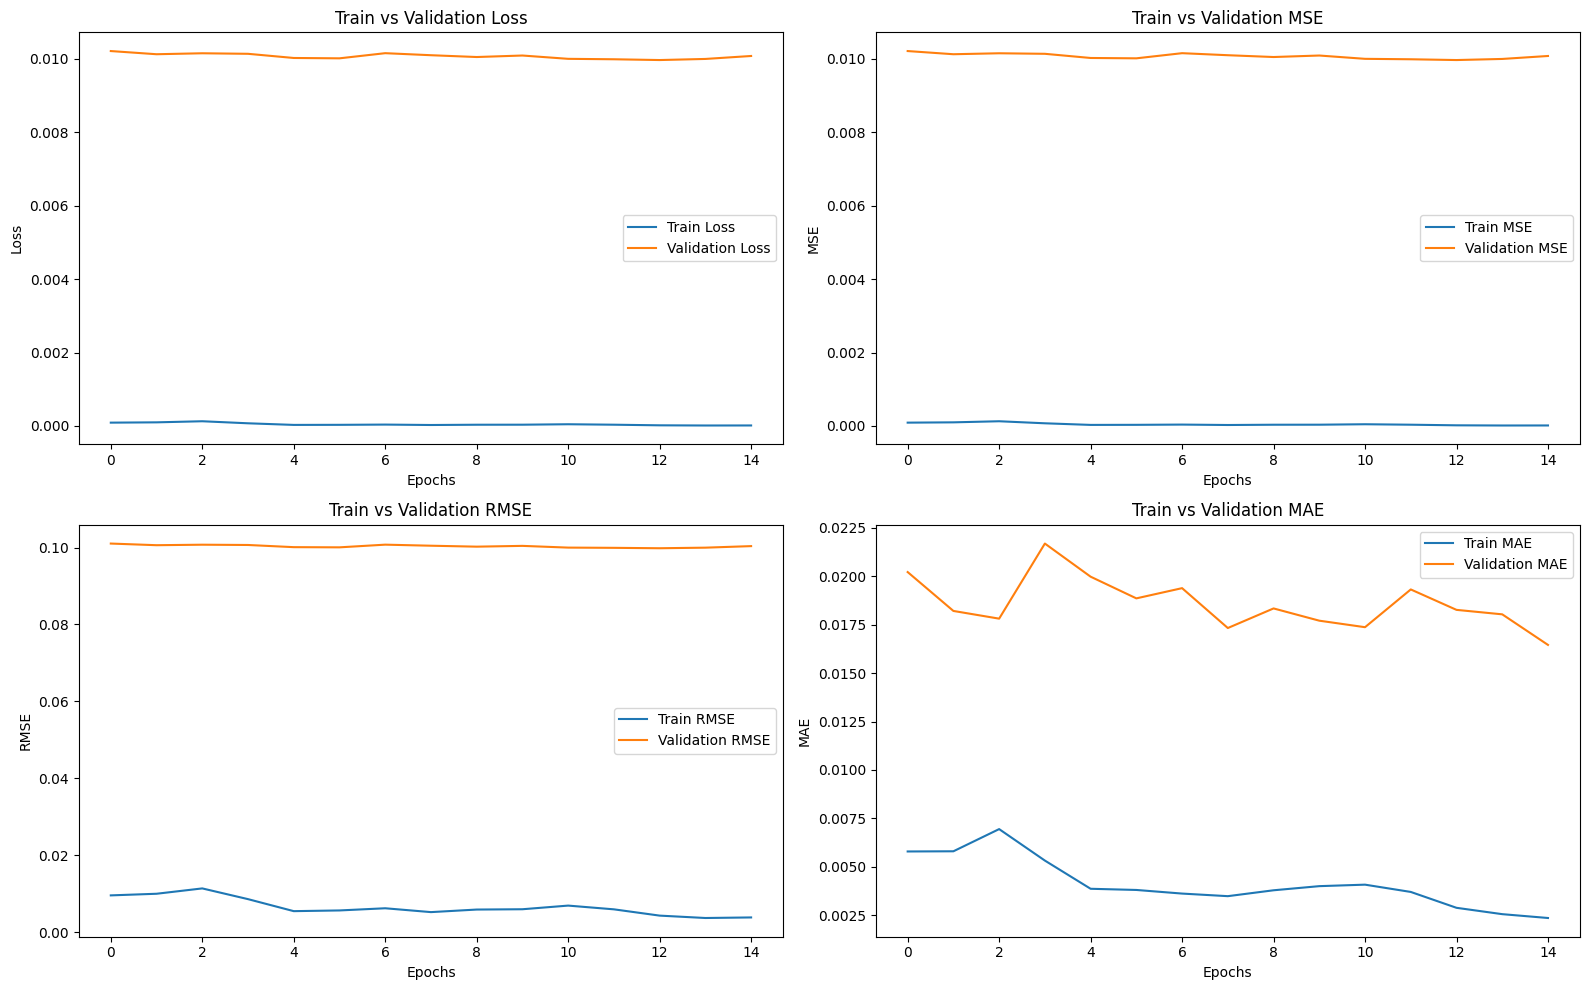

In [47]:
import matplotlib.pyplot as plt

# Configurar el tamaño de la figura
plt.figure(figsize=(16, 10))

# Gráfico para la pérdida de entrenamiento y validación
plt.subplot(2, 2, 1)
plt.plot(metrics_df['Train Loss'], label='Train Loss')
plt.plot(metrics_df['Validation Loss'], label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Gráfico para MSE de entrenamiento y validación
plt.subplot(2, 2, 2)
plt.plot(metrics_df['Train MSE'], label='Train MSE')
plt.plot(metrics_df['Validation MSE'], label='Validation MSE')
plt.title('Train vs Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

# Gráfico para RMSE de entrenamiento y validación
plt.subplot(2, 2, 3)
plt.plot(metrics_df['Train RMSE'], label='Train RMSE')
plt.plot(metrics_df['Validation RMSE'], label='Validation RMSE')
plt.title('Train vs Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

# Gráfico para MAE de entrenamiento y validación
plt.subplot(2, 2, 4)
plt.plot(metrics_df['Train MAE'], label='Train MAE')
plt.plot(metrics_df['Validation MAE'], label='Validation MAE')
plt.title('Train vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

# Mostrar todos los gráficos
plt.tight_layout()
plt.show()